# Importálások

In [2]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import scipy.interpolate
import h5py
import pandas as pd 
import seaborn as sns
import time

# Címkék beolvasása datasetenként

In [3]:
ff10=np.loadtxt("../data/labels/ff1010bird.csv",dtype=str,delimiter=",",skiprows=1)
warb=np.loadtxt("../data/labels/warblrb10k.csv",dtype=str,delimiter=",",skiprows=1)

# Felvételek hosszainak elemzése

## ff10 felvételek hosszainak elemzése

In [3]:
ff10_times=[]
for i in range(len(ff10)):
    itemid=ff10[i,0]
    fn_test = "../data/audio/ff1010bird/{}.wav".format(itemid) #elérési útvonal legyártása
    fs, data = scipy.io.wavfile.read(fn_test) #fs=44100
    ff10_times.append(data.shape[0]/fs)
ff10_times=np.array(ff10_times)

KeyboardInterrupt: 

In [4]:
print("A felvételek elemszáma összesen: {} db".format(len(ff10_times)))
print("Az ff10 dataset minden felvételének hossza megegyezik 10 másodperccel: {}.".format(sum(ff10_times == 10) == len(ff10_times)))

A felvételek elemszáma összesen: 7690 db
Az ff10 dataset minden felvételének hossza megegyezik 10 másodperccel: True.


Konklúzió: a spectrogramok elkészítése az ff10 dataset esetében problémamentes

## warb felvételek hosszainak elemzése

In [4]:
warb_times=[]
for i in range(len(warb)):
    itemid=warb[i,0]
    fn_test = "../data/audio/warblrb10k/{}.wav".format(itemid) #elérési útvonal legyártása
    fs, data = scipy.io.wavfile.read(fn_test) #fs=44100
    warb_times.append(data.shape[0]/fs)
warb_times=np.array(warb_times)

In [5]:
print("A felvételek elemszáma összesen: {} db".format(len(warb_times)))
print("Az ff10 dataset minden felvételének hossza megegyezik 10 másodperccel: {}.".format(sum(np.array(warb_times) == 10) == len(warb_times)))

A felvételek elemszáma összesen: 8000 db
Az ff10 dataset minden felvételének hossza megegyezik 10 másodperccel: False.


Itt gond van, a felvételek hossza nem minden esetben megfelelő, a hibás hosszok aránya még ismeretlen.
A probléma feltárásához további vizsgálat szükséges (például a felvételek hosszainak eloszlása).

In [6]:
print("A warb dataset legrövidebb felvétele: {} s".format(min(warb_times)))
print("A warb dataset leghosszabb felvétele: {} s".format(max(warb_times)))
print("A warb dataset felvételhosszainak átlaga: {} s".format(np.mean(warb_times)))
print("A warb dataset felvételhosszainak szórása: {} s".format(np.std(warb_times))) #elég nagy

A warb dataset legrövidebb felvétele: 0.96 s
A warb dataset leghosszabb felvétele: 48.41360544217687 s
A warb dataset felvételhosszainak átlaga: 10.081670873015874 s
A warb dataset felvételhosszainak szórása: 0.5588186811273453 s


A következő hisztogram a felvételhosszok eloszlását ábrázolja. A két függőleges szaggatott vonal az 1%-on belüli eltérést hivatott jelezni ($\pm 0.1 s$)

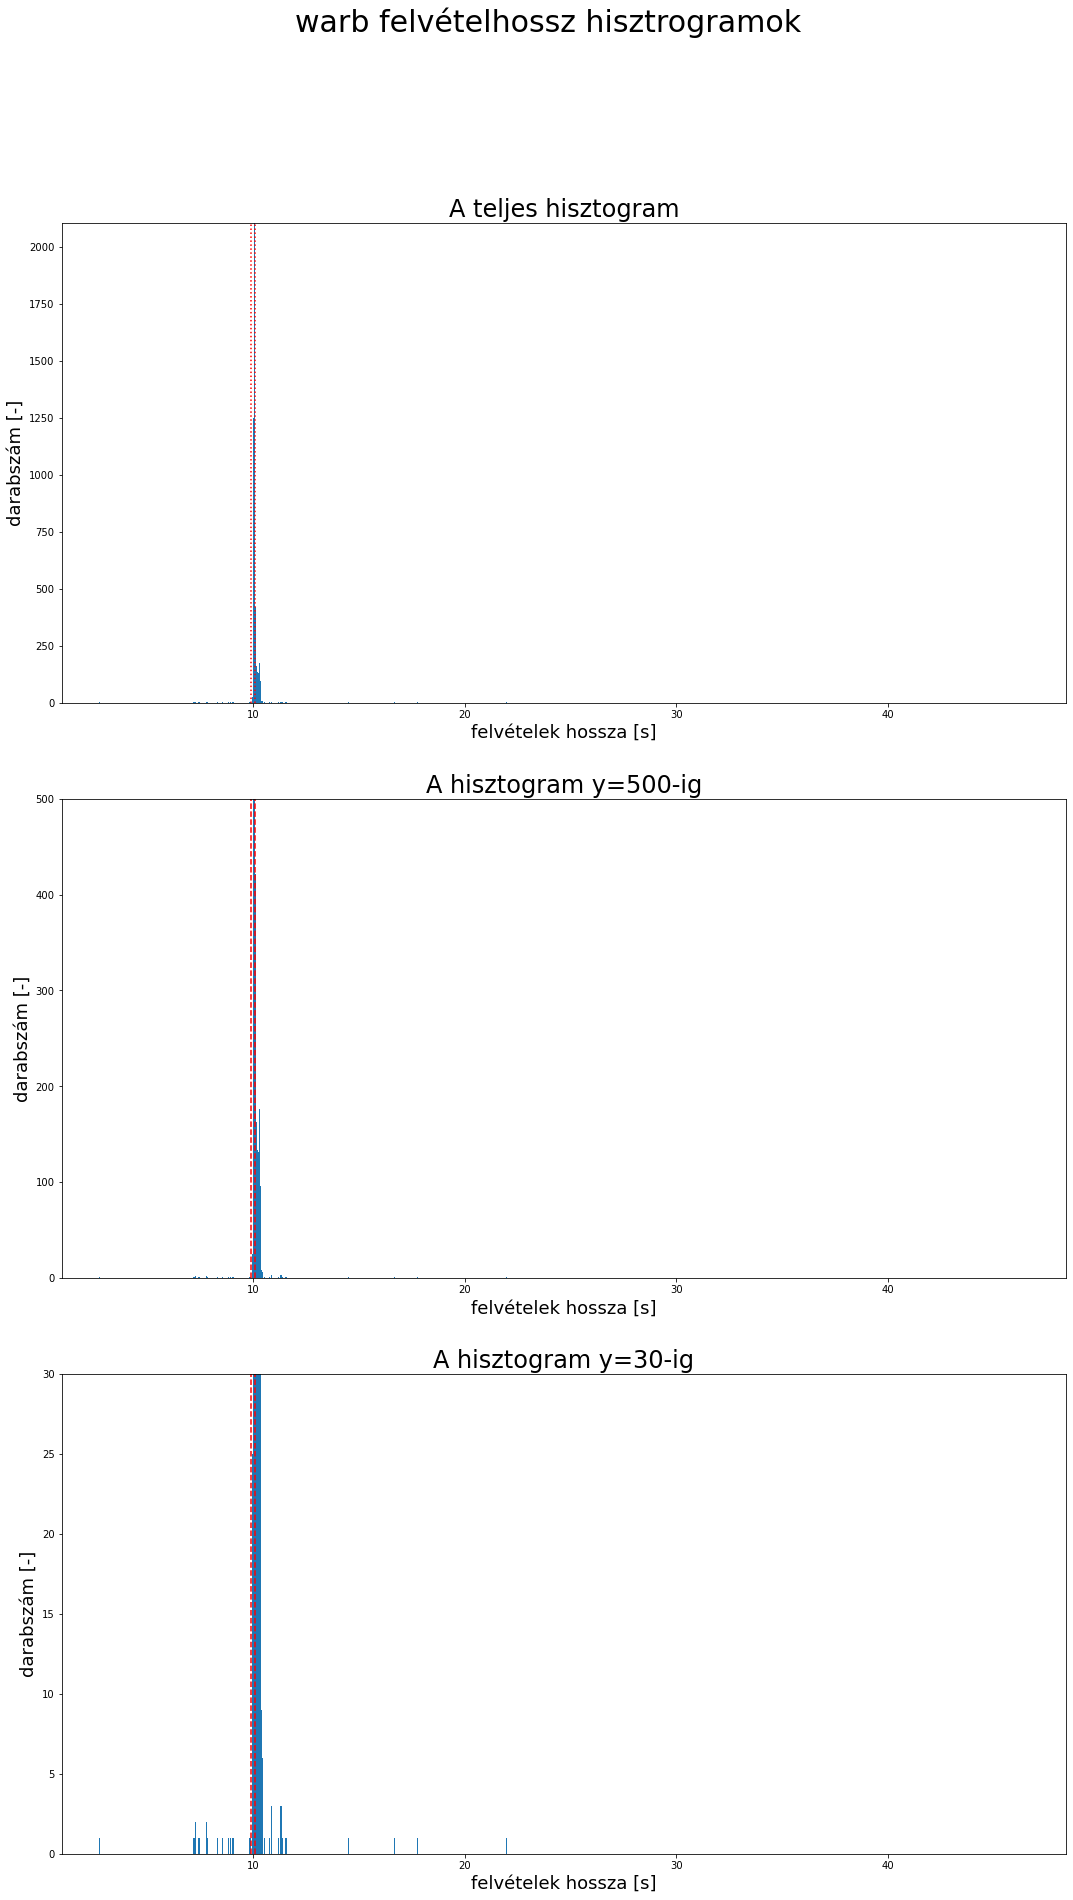

In [8]:
fig=plt.figure(figsize=(18,30))
fig.suptitle("warb felvételhossz hisztrogramok",fontsize=30)
ax1=plt.subplot(311)
valbin=ax1.hist(warb_times,bins=2000)
vals=np.array([int(i) for i in valbin[0]])
bins=valbin[1]
ax1.vlines(9.9, 0,max(vals) , linestyles ="dotted", colors ="r")
ax1.vlines(10.1, 0,max(vals) , linestyles ="dotted", colors ="r")
ax1.set_xlim(min(warb_times),max(warb_times))
ax1.set_ylim(min(vals),max(vals))
ax1.set_xlabel("felvételek hossza [s]",fontsize=18)
ax1.set_ylabel("darabszám [-]",fontsize=18)
ax1.set_title("A teljes hisztogram",fontsize=24)

ax2=plt.subplot(312)
valbin=ax2.hist(warb_times,bins=2000)
vals=np.array([int(i) for i in valbin[0]])
bins=valbin[1]
ax2.vlines(9.9, 0,max(vals) , linestyles ="dashed", colors ="r")
ax2.vlines(10.1, 0,max(vals) , linestyles ="dashed", colors ="r")
ax2.set_xlim(min(warb_times),max(warb_times))
ax2.set_ylim(min(vals),500)
ax2.set_xlabel("felvételek hossza [s]",fontsize=18)
ax2.set_ylabel("darabszám [-]",fontsize=18)
ax2.set_title("A hisztogram y=500-ig",fontsize=24)

ax3=plt.subplot(313)
valbin=ax3.hist(warb_times,bins=2000)
vals=np.array([int(i) for i in valbin[0]])
bins=valbin[1]
ax3.vlines(9.9, 0,max(vals) , linestyles ="dashed", colors ="r")
ax3.vlines(10.1, 0,max(vals) , linestyles ="dashed", colors ="r")
ax3.set_xlim(min(warb_times),max(warb_times))
ax3.set_ylim(min(vals),30)
ax3.set_xlabel("felvételek hossza [s]",fontsize=18)
ax3.set_ylabel("darabszám [-]",fontsize=18)
ax3.set_title("A hisztogram y=30-ig",fontsize=24);

In [12]:
print("Felvételek száma, melynek hossza kisebb mint 10s: {} db".format(sum(warb_times<10)))
print("Felvételek száma, melynek hossza nagyobb mint 10s: {} db".format(sum(warb_times>10)))
print("Felvételek száma, melynek hossza pontosan 10s: {} db".format(sum(warb_times==10)))

Felvételek száma, melynek hossza kisebb mint 10s: 409 db
Felvételek száma, melynek hossza nagyobb mint 10s: 7590 db
Felvételek száma, melynek hossza pontosan 10s: 1 db


10 másodperc alatt és fölött is bőven vannak elemek, illetve csak egy felvételnek pontosan 10 másodperces a hossza. Megoldási ötlet: tartsuk meg csak azokat az elemeket, amik 1%-os hibahatáron belül találhatók a szükséges felvételhosszhoz képest (10 s).

### Lefele vágás

In [8]:
print("Felvételek száma, melynek hossza kisebb mint 9.9s: {} db".format(sum(warb_times<9.9)))

Felvételek száma, melynek hossza kisebb mint 9.9s: 32 db


Ez a 32 elem már elhanyagolható a teljes elemszámhoz képest, nem érdemes vele foglalkozni.

### Felfele vágás

In [9]:
print("Felvételek száma, melynek hossza nagyobb mint 10.1s: {} db".format(sum(warb_times>10.1)))

Felvételek száma, melynek hossza nagyobb mint 10.1s: 1932 db


Ez meglehetősen nagy szám, de egy plusz ötlettel még lehet javítani az értéken: vegyük bele az összes 10.1-nél nagyobb, de 0 címkéjű felvételt, a többletet gond nélkül levághatjuk később, mivel a felvétel nem tartalmazott madárfüttyöt, így nem is tudtuk azt kivágni belőle és elrontani a címkét (a madárfüttyöt tartalmazó felvételekkel ellentétben, ahol a kivágást csak manuálisan lehetne elvégezni).

In [10]:
counts=[]
for i in range(len(warb)):
    if (warb_times[i]>10.1 and int(warb[i,1])):
        counts.append(True)
    else:
        counts.append(False)
print("Felvételek száma, melynek hossza nagyobb mint 10.1s és tartalmaz füttyöt: {} db".format(sum(counts)))

Felvételek száma, melynek hossza nagyobb mint 10.1s és tartalmaz füttyöt: 1470 db


Ezen már nincs ötletem, hogy lehetne segíteni (leszámítva a manuális újracímkézést).

# Eredeti (bulbul) megoldás

14 másodperces felvételeket használtak, a rövidebbeket addig loopolták, amíg el nem érték a kívánt hosszt, a hosszabbakat valószíneg kivágták.

In [5]:
print("Felvételek száma, melynek hossza nagyobb mint 14s: {} db".format(sum(warb_times>14)))

Felvételek száma, melynek hossza nagyobb mint 14s: 9 db


In [6]:
counts=[]
for i in range(len(warb)):
    if (warb_times[i]>14 and int(warb[i,1])):
        counts.append(True)
    else:
        counts.append(False)
print("Felvételek száma, melynek hossza nagyobb mint 14s és tartalmaz füttyöt: {} db".format(sum(counts)))

Felvételek száma, melynek hossza nagyobb mint 14s és tartalmaz füttyöt: 2 db


Ez megegyezik a szükséges kivágások számával (9 db elhanyagolható).

A rövidebb felvételek meghosszabbításához kellene egy jó loopolási függvény, ami össze tudja simítani a felvételen keletkező szakadásokat (Stéger már írt egy ilyet, elküldte skypon).

In [7]:
counts=[]
for i in range(len(warb)):
    if (warb_times[i]>14 and int(warb[i,1])):
        counts.append(True)
    else:
        counts.append(False)
print("Felvételek száma, melynek hossza nagyobb mint 14s és tartalmaz füttyöt: {} db".format(sum(counts)))

Felvételek száma, melynek hossza nagyobb mint 14s és tartalmaz füttyöt: 2 db


### Így végül elegendő összesen két darab felvételt eldobni az egészből (bár két darabot már manuálisan is meg lehetne hallgatni).

## Végső kivágás a warb dataset-ből és mentés cvs-be (saját, 9.9-10.1s között)

In [8]:
filter_array=[]
for i in range(len(warb_times)):
    if (warb_times[i]>9.9 and (warb_times[i]<10.1 or int(warb[i,1])==0)):
        filter_array.append(True)
    else:
        filter_array.append(False)
filter_array=np.array(filter_array)
warb_filtered_own=warb[filter_array]
print("A kivágások után a warb datasetben maradt felvételek száma: {} db.".format(len(warb_filtered_own)))

pd.DataFrame(warb_filtered_own).to_csv("../data/labels/warblrb10k_filtered_own.csv",index=False)

A kivágások után a warb datasetben maradt felvételek száma: 6498 db.


## Végső kivágás a warb dataset-ből és mentés cvs-be (bulbul, 14s fölött)

In [9]:
filter_array=[]
for i in range(len(warb_times)):
    if (warb_times[i]<=14 or int(warb[i,1])==0):
        filter_array.append(True)
    else:
        filter_array.append(False)
filter_array=np.array(filter_array)
warb_filtered_bulbul=warb[filter_array]
print("A kivágások után a warb datasetben maradt felvételek száma: {} db.".format(len(warb_filtered_bulbul)))

pd.DataFrame(warb_filtered_bulbul).to_csv("../data/labels/warblrb10k_filtered_bulbul.csv",index=False)

A kivágások után a warb datasetben maradt felvételek száma: 7998 db.


# Új felvétel útvonalak beolvasása

In [3]:
ff10=np.loadtxt("./labels/ff1010bird.csv",dtype=str,delimiter=",",skiprows=1)
print("ff10 megmaradt felvételek száma: {} db".format(len(ff10)))
warb=np.loadtxt("./labels/warblrb10k_filtered.csv",dtype=str,delimiter=",",skiprows=1)
print("warb megmaradt felvételek száma: {} db".format(len(warb)))

ff10 megmaradt felvételek száma: 7690 db
warb megmaradt felvételek száma: 6498 db


In [4]:
#A kártyához szükséges adatok
#*: az eredeti megoldásból vett értékek

n_s = 700 #*
n_f = 80 #*

fmax = 11000 #Hz *
fmin = 0 #Hz ; eredeti megoldásban 50 Hz ; végeredményben 137.5 Hz frekvencia lesz a minimális
t_felv = 10 #s *
f_star = 2 * fmax #újramintavételezési frekvencia
t_window = n_f / (fmax - fmin)
n_window = int(np.ceil(f_star * t_window)) #ellenőrizve
delta_t_window = (t_felv - t_window) / (n_s-1) #ellenőrizve

#f_ax = np.linspace(fmin, fmax, n_f) #jó
#t_ax = np.linspace(0, t_max - t_window, n_s) #jó

fax_ = np.fft.rfftfreq(n_window, 1/f_star)

In [49]:
#A kártyához szükséges adatok
#*: az eredeti megoldásból vett értékek

n_s = 700 #*
n_f = 80 #*

fmax = 11000 #Hz *
fmin = 0 #Hz ; eredeti megoldásban 50 Hz ; végeredményben 137.5 Hz frekvencia lesz a minimális
t_felv = 10 #s *
f_star = 2 * fmax #újramintavételezési frekvencia
n_window=630 # 10 s -> 441000 pont ->441000/700=630

441000/700

630.0

In [48]:
10/700

0.014285714285714285

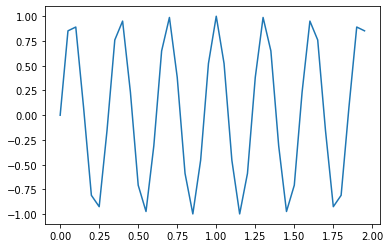

In [50]:
x=np.linspace(0,2,40,endpoint=False) #f*=20/s, N=40
y=np.sin(2*np.pi*3.25*x)
plt.plot(x,y)

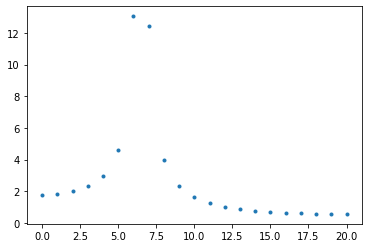

In [63]:
F=np.fft.rfft(y)
plt.plot(abs(F),'.')

In [64]:
f1=np.linspace(0,20,21,endpoint=True)
F1=scipy.interpolate.interp1d(f1,F)

In [65]:
f2=np.linspace(0,20,201)
F2=F1(f2)

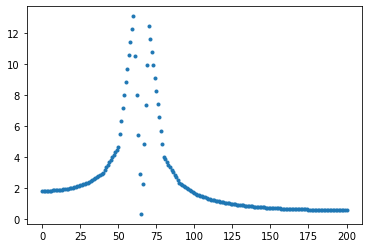

In [66]:
plt.plot(abs(F2),'.')

In [69]:
y1=np.fft.irfft(F)
y2=np.fft.irfft(F2)

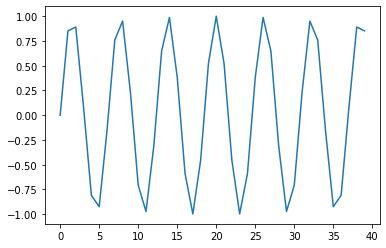

In [70]:
plt.plot(y1)

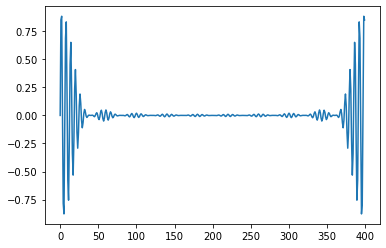

In [68]:
plt.plot(y2)

In [14]:
441000/80

5512.5

In [17]:
10/80

0.125

In [16]:
n_window

160

In [12]:
hanning=np.hanning(n_window)

In [6]:
fn_test = "./audio/ff1010bird/{}.wav".format(ff10[0,0]) #elérési útvonal legyártása
fs, data = scipy.io.wavfile.read(fn_test) #felvétel beolvasása, fs=44100/s

t0 = 0
t_dur = 10

data_cub = scipy.interpolate.interp1d(np.arange(data.shape[0]) / fs, data, kind='cubic') #interpoláció (köbös)
t_sample = np.linspace(0, t_window, n_window,endpoint=False)

In [9]:
np.arange(data.shape[0])

array([     0,      1,      2, ..., 440997, 440998, 440999])

In [13]:
t_sample[-1]*700

5.059090909090909

In [1]:
def resample_wav(fs, data, new_data_len):
    '''A függvény new_data_len / fs hosszú időtartamúra konvertálja a beadott adatsort,
       miközbens fs-t változatlanul hagyja. Ez a felvétel lejátszási sebességének változását eredményezi.
       
       fs:=eredeti mintavételezési frekvencia
       data:=eredeti adatpontok a felvételen
       new_data_len:=az új adatsor elemszáma'''
    
    T = new_data_len / fs #kívánt időtartam
    t_original = np.linspace(0, T, data.shape[0], endpoint = False) # az eredeti adatpontokhoz tartozó új időpontok
    t_new = np.linspace(0, T, new_data_len, endpoint = False) # a kívánt elemszámhoz az új időpontok
    fun_interp = scipy.interpolate.interp1d(t_original, data, kind="cubic")
    new_data = fun_interp(t_new)
    return fs, new_data

In [ ]:
# fontos megjegyzés: ez csak a szervergép memóriájával működik, egyébként egyesével kell menteni a fájlokat
def make_spectogram(id_label):

    tx = time.process_time()

    dataset_imgs=[]
    dataset_labels=[]

    for i in range(10):
        itemid=id_label[i,0]
        label=int(id_label[i,1])
        cardi=[]

        fn_test = "./audio/ff1010bird/{}.wav".format(itemid) #elérési útvonal legyártása
        fs, data = scipy.io.wavfile.read(fn_test) #felvétel beolvasása, fs=44100/s
        
        if data.shape[0] != 441000:
            fs, data = resample_wav(fs,data,441000) # t * fs

        t0 = 0
        t_dur = 10
        
        data_cub = scipy.interpolate.interp1d(np.arange(data.shape[0]) / fs, data, kind='cubic') #interpoláció (köbös)
        t_sample = np.linspace(0, t_window, n_window,endpoint=False) #időpontok legyártása a fütty kezdete és hossza segítségével
        for j in range(n_s):
            print(t_sample[-1])
            print("HERE {}".format(len(t_sample)))
            matrix=abs(np.fft.rfft(hanning*data_cub(t_sample)))
            #sp_ = np.log10(matrix, out=np.zeros_like(matrix), where=(matrix!=0)) #megoldja a problémát a 0 helyeken
            sp_cub=scipy.interpolate.interp1d(fax_, matrix,kind='cubic') #interpolálok és újraillesztem az értékeket az f_ax skálán
            sp_helyen=sp_cub(f_ax)
            cardi.append(sp_helyen)
            t_sample+=delta_t_window
        cardi=np.array([np.array(cardi)])
        ff10_imgs.append(cardi)
        ff10_labels.append(label)
        #np.savetxt("./matrixok_vel/card{}.csv".format(syl.index[test_index]), cardi, delimiter=",") #létre kell hozni a két mappát futtatás előtt
        #svm=sns.heatmap(cardi)
        #figure = svm.get_figure()    
        #figure.savefig('./kepek/kep{}.png'.format(syl.index[test_index]), dpi=400)
        #plt.clf()

    ff10_imgs=np.concatenate(ff10_imgs,axis=0)
    ff10_labels=np.array(ff10_labels)

    f=h5py.File("ff10.h5","w")
    f.create_dataset("imgs", data=ff10_imgs)
    f.create_dataset("labels", data=ff10_labels)
    f.close()

    ty=time.process_time()
    print("Time={} s".format(ty-tx))

In [16]:
def make_spectogram(id_label):
    

tx = time.process_time()

ff10_imgs=[]
ff10_labels=[]

for i in range(10):
    itemid=ff10[i,0]
    label=int(ff10[i,1])
    cardi=[]
    
    fn_test = "./audio/ff1010bird/{}.wav".format(itemid) #elérési útvonal legyártása
    fs, data = scipy.io.wavfile.read(fn_test) #fs=44100
    
    t0 = 0
    t_dur = 10

    data=data/np.std(data[0:int(fs*t_dur)]) #normálás az amplitúdó szórásával
    data_cub = scipy.interpolate.interp1d(np.arange(data.shape[0]) / fs, data, kind='cubic') #interpoláció (köbös)
    
    t_sample = np.linspace(0, t_window, n_window,endpoint=False) #időpontok legyártása a fütty kezdete és hossza segítségével
    for j in range(n_s):
        print(t_sample[-1])
        print("HERE {}".format(len(t_sample)))
        matrix=abs(np.fft.rfft(hanning*data_cub(t_sample)))
        #sp_ = np.log10(matrix, out=np.zeros_like(matrix), where=(matrix!=0)) #megoldja a problémát a 0 helyeken
        sp_cub=scipy.interpolate.interp1d(fax_, matrix,kind='cubic') #interpolálok és újraillesztem az értékeket az f_ax skálán
        sp_helyen=sp_cub(f_ax)
        cardi.append(sp_helyen)
        t_sample+=delta_t_window
    cardi=np.array([np.array(cardi)])
    ff10_imgs.append(cardi)
    ff10_labels.append(label)
    #np.savetxt("./matrixok_vel/card{}.csv".format(syl.index[test_index]), cardi, delimiter=",") #létre kell hozni a két mappát futtatás előtt
    #svm=sns.heatmap(cardi)
    #figure = svm.get_figure()    
    #figure.savefig('./kepek/kep{}.png'.format(syl.index[test_index]), dpi=400)
    #plt.clf()

ff10_imgs=np.concatenate(ff10_imgs,axis=0)
ff10_labels=np.array(ff10_labels)

f=h5py.File("ff10.h5","w")
f.create_dataset("imgs", data=ff10_imgs)
f.create_dataset("labels", data=ff10_labels)
f.close()

ty=time.process_time()
print("Time={} s".format(ty-tx))

441000
0.0072608377022380065
HERE 162
0.021556537364508306
HERE 162
0.03585223702677861
HERE 162
0.05014793668904891
HERE 162
0.06444363635131921
HERE 162
0.07873933601358951
HERE 162
0.09303503567585981
HERE 162
0.10733073533813012
HERE 162
0.12162643500040042
HERE 162
0.13592213466267072
HERE 162
0.150217834324941
HERE 162
0.1645135339872113
HERE 162
0.1788092336494816
HERE 162
0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795

5.396739610378146
HERE 162
5.4110353100404165
HERE 162
5.425331009702687
HERE 162
5.439626709364957
HERE 162
5.453922409027227
HERE 162
5.468218108689497
HERE 162
5.482513808351767
HERE 162
5.496809508014037
HERE 162
5.511105207676307
HERE 162
5.525400907338577
HERE 162
5.539696607000847
HERE 162
5.553992306663117
HERE 162
5.568288006325387
HERE 162
5.582583705987657
HERE 162
5.596879405649927
HERE 162
5.611175105312197
HERE 162
5.6254708049744675
HERE 162
5.639766504636738
HERE 162
5.654062204299008
HERE 162
5.668357903961278
HERE 162
5.682653603623548
HERE 162
5.696949303285818
HERE 162
5.711245002948088
HERE 162
5.725540702610358
HERE 162
5.739836402272628
HERE 162
5.754132101934898
HERE 162
5.768427801597168
HERE 162
5.782723501259438
HERE 162
5.797019200921708
HERE 162
5.811314900583978
HERE 162
5.825610600246248
HERE 162
5.8399062999085185
HERE 162
5.854201999570789
HERE 162
5.868497699233059
HERE 162
5.882793398895329
HERE 162
5.897089098557599
HERE 162
5.911384798219869
HERE 16

0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795
HERE 162
0.5076103258816983
HERE 162
0.5219060255439686
HERE 162
0.5362017252062389
HERE 162
0.5504974248685092
HERE 162
0.5647931245307795
HERE 162
0.5790888241930497
HERE 162
0.59338452385532
HERE 162
0.6076802235175903
HERE 162
0.6219759231798606
HERE 162
0.6362716228421309
HERE 162
0.6505673225044012
HERE 162
0.6648630221666715
HERE 162
0.6791587218289418
HERE 162
0.693454421

6.869196675591963
HERE 162
6.883492375254233
HERE 162
6.8977880749165035
HERE 162
6.9120837745787735
HERE 162
6.926379474241044
HERE 162
6.940675173903314
HERE 162
6.954970873565584
HERE 162
6.969266573227854
HERE 162
6.983562272890124
HERE 162
6.997857972552394
HERE 162
7.012153672214664
HERE 162
7.026449371876934
HERE 162
7.040745071539204
HERE 162
7.055040771201474
HERE 162
7.069336470863744
HERE 162
7.083632170526014
HERE 162
7.097927870188284
HERE 162
7.1122235698505545
HERE 162
7.1265192695128246
HERE 162
7.140814969175095
HERE 162
7.155110668837365
HERE 162
7.169406368499635
HERE 162
7.183702068161905
HERE 162
7.197997767824175
HERE 162
7.212293467486445
HERE 162
7.226589167148715
HERE 162
7.240884866810985
HERE 162
7.255180566473255
HERE 162
7.269476266135525
HERE 162
7.283771965797795
HERE 162
7.298067665460065
HERE 162
7.312363365122335
HERE 162
7.3266590647846055
HERE 162
7.340954764446876
HERE 162
7.355250464109146
HERE 162
7.369546163771416
HERE 162
7.383841863433686
HERE 

4.967868620510044
HERE 162
4.9821643201723145
HERE 162
4.9964600198345845
HERE 162
5.010755719496855
HERE 162
5.025051419159125
HERE 162
5.039347118821395
HERE 162
5.053642818483665
HERE 162
5.067938518145935
HERE 162
5.082234217808205
HERE 162
5.096529917470475
HERE 162
5.110825617132745
HERE 162
5.125121316795015
HERE 162
5.139417016457285
HERE 162
5.153712716119555
HERE 162
5.168008415781825
HERE 162
5.182304115444095
HERE 162
5.1965998151063655
HERE 162
5.2108955147686356
HERE 162
5.225191214430906
HERE 162
5.239486914093176
HERE 162
5.253782613755446
HERE 162
5.268078313417716
HERE 162
5.282374013079986
HERE 162
5.296669712742256
HERE 162
5.310965412404526
HERE 162
5.325261112066796
HERE 162
5.339556811729066
HERE 162
5.353852511391336
HERE 162
5.368148211053606
HERE 162
5.382443910715876
HERE 162
5.396739610378146
HERE 162
5.4110353100404165
HERE 162
5.425331009702687
HERE 162
5.439626709364957
HERE 162
5.453922409027227
HERE 162
5.468218108689497
HERE 162
5.482513808351767
HERE 

0.1645135339872113
HERE 162
0.1788092336494816
HERE 162
0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795
HERE 162
0.5076103258816983
HERE 162
0.5219060255439686
HERE 162
0.5362017252062389
HERE 162
0.5504974248685092
HERE 162
0.5647931245307795
HERE 162
0.5790888241930497
HERE 162
0.59338452385532
HERE 162
0.6076802235175903
HERE 162
0.6219759231798606
HERE 162
0.6362716228421309
HERE 162
0.6505673225044012
HERE 162
0.664863022

7.812712853301788
HERE 162
7.827008552964058
HERE 162
7.841304252626328
HERE 162
7.855599952288598
HERE 162
7.869895651950868
HERE 162
7.884191351613138
HERE 162
7.898487051275408
HERE 162
7.912782750937678
HERE 162
7.927078450599948
HERE 162
7.941374150262218
HERE 162
7.9556698499244884
HERE 162
7.9699655495867585
HERE 162
7.984261249249029
HERE 162
7.998556948911299
HERE 162
8.012852648573569
HERE 162
8.027148348235839
HERE 162
8.041444047898109
HERE 162
8.055739747560379
HERE 162
8.070035447222649
HERE 162
8.084331146884919
HERE 162
8.09862684654719
HERE 162
8.11292254620946
HERE 162
8.12721824587173
HERE 162
8.141513945534
HERE 162
8.15580964519627
HERE 162
8.17010534485854
HERE 162
8.18440104452081
HERE 162
8.19869674418308
HERE 162
8.21299244384535
HERE 162
8.22728814350762
HERE 162
8.24158384316989
HERE 162
8.25587954283216
HERE 162
8.27017524249443
HERE 162
8.2844709421567
HERE 162
8.29876664181897
HERE 162
8.31306234148124
HERE 162
8.32735804114351
HERE 162
8.34165374080578
HE

3.9814653438134093
HERE 162
3.99576104347568
HERE 162
4.01005674313795
HERE 162
4.02435244280022
HERE 162
4.03864814246249
HERE 162
4.05294384212476
HERE 162
4.06723954178703
HERE 162
4.0815352414493
HERE 162
4.09583094111157
HERE 162
4.11012664077384
HERE 162
4.1244223404361104
HERE 162
4.1387180400983805
HERE 162
4.153013739760651
HERE 162
4.167309439422921
HERE 162
4.181605139085191
HERE 162
4.195900838747461
HERE 162
4.210196538409731
HERE 162
4.224492238072001
HERE 162
4.238787937734271
HERE 162
4.253083637396541
HERE 162
4.267379337058811
HERE 162
4.281675036721081
HERE 162
4.295970736383351
HERE 162
4.310266436045621
HERE 162
4.324562135707891
HERE 162
4.3388578353701615
HERE 162
4.3531535350324315
HERE 162
4.367449234694702
HERE 162
4.381744934356972
HERE 162
4.396040634019242
HERE 162
4.410336333681512
HERE 162
4.424632033343782
HERE 162
4.438927733006052
HERE 162
4.453223432668322
HERE 162
4.467519132330592
HERE 162
4.481814831992862
HERE 162
4.496110531655132
HERE 162
4.5104

0.0072608377022380065
HERE 162
0.021556537364508306
HERE 162
0.03585223702677861
HERE 162
0.05014793668904891
HERE 162
0.06444363635131921
HERE 162
0.07873933601358951
HERE 162
0.09303503567585981
HERE 162
0.10733073533813012
HERE 162
0.12162643500040042
HERE 162
0.13592213466267072
HERE 162
0.150217834324941
HERE 162
0.1645135339872113
HERE 162
0.1788092336494816
HERE 162
0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795
HERE 1

7.212293467486445
HERE 162
7.226589167148715
HERE 162
7.240884866810985
HERE 162
7.255180566473255
HERE 162
7.269476266135525
HERE 162
7.283771965797795
HERE 162
7.298067665460065
HERE 162
7.312363365122335
HERE 162
7.3266590647846055
HERE 162
7.340954764446876
HERE 162
7.355250464109146
HERE 162
7.369546163771416
HERE 162
7.383841863433686
HERE 162
7.398137563095956
HERE 162
7.412433262758226
HERE 162
7.426728962420496
HERE 162
7.441024662082766
HERE 162
7.455320361745036
HERE 162
7.469616061407306
HERE 162
7.483911761069576
HERE 162
7.498207460731846
HERE 162
7.512503160394116
HERE 162
7.526798860056386
HERE 162
7.5410945597186565
HERE 162
7.555390259380927
HERE 162
7.569685959043197
HERE 162
7.583981658705467
HERE 162
7.598277358367737
HERE 162
7.612573058030007
HERE 162
7.626868757692277
HERE 162
7.641164457354547
HERE 162
7.655460157016817
HERE 162
7.669755856679087
HERE 162
7.684051556341357
HERE 162
7.698347256003627
HERE 162
7.712642955665897
HERE 162
7.726938655328167
HERE 162

4.03864814246249
HERE 162
4.05294384212476
HERE 162
4.06723954178703
HERE 162
4.0815352414493
HERE 162
4.09583094111157
HERE 162
4.11012664077384
HERE 162
4.1244223404361104
HERE 162
4.1387180400983805
HERE 162
4.153013739760651
HERE 162
4.167309439422921
HERE 162
4.181605139085191
HERE 162
4.195900838747461
HERE 162
4.210196538409731
HERE 162
4.224492238072001
HERE 162
4.238787937734271
HERE 162
4.253083637396541
HERE 162
4.267379337058811
HERE 162
4.281675036721081
HERE 162
4.295970736383351
HERE 162
4.310266436045621
HERE 162
4.324562135707891
HERE 162
4.3388578353701615
HERE 162
4.3531535350324315
HERE 162
4.367449234694702
HERE 162
4.381744934356972
HERE 162
4.396040634019242
HERE 162
4.410336333681512
HERE 162
4.424632033343782
HERE 162
4.438927733006052
HERE 162
4.453223432668322
HERE 162
4.467519132330592
HERE 162
4.481814831992862
HERE 162
4.496110531655132
HERE 162
4.510406231317402
HERE 162
4.524701930979672
HERE 162
4.538997630641942
HERE 162
4.5532933303042125
HERE 162
4.5

0.0072608377022380065
HERE 162
0.021556537364508306
HERE 162
0.03585223702677861
HERE 162
0.05014793668904891
HERE 162
0.06444363635131921
HERE 162
0.07873933601358951
HERE 162
0.09303503567585981
HERE 162
0.10733073533813012
HERE 162
0.12162643500040042
HERE 162
0.13592213466267072
HERE 162
0.150217834324941
HERE 162
0.1645135339872113
HERE 162
0.1788092336494816
HERE 162
0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795
HERE 1

7.055040771201474
HERE 162
7.069336470863744
HERE 162
7.083632170526014
HERE 162
7.097927870188284
HERE 162
7.1122235698505545
HERE 162
7.1265192695128246
HERE 162
7.140814969175095
HERE 162
7.155110668837365
HERE 162
7.169406368499635
HERE 162
7.183702068161905
HERE 162
7.197997767824175
HERE 162
7.212293467486445
HERE 162
7.226589167148715
HERE 162
7.240884866810985
HERE 162
7.255180566473255
HERE 162
7.269476266135525
HERE 162
7.283771965797795
HERE 162
7.298067665460065
HERE 162
7.312363365122335
HERE 162
7.3266590647846055
HERE 162
7.340954764446876
HERE 162
7.355250464109146
HERE 162
7.369546163771416
HERE 162
7.383841863433686
HERE 162
7.398137563095956
HERE 162
7.412433262758226
HERE 162
7.426728962420496
HERE 162
7.441024662082766
HERE 162
7.455320361745036
HERE 162
7.469616061407306
HERE 162
7.483911761069576
HERE 162
7.498207460731846
HERE 162
7.512503160394116
HERE 162
7.526798860056386
HERE 162
7.5410945597186565
HERE 162
7.555390259380927
HERE 162
7.569685959043197
HERE 1

3.666959951243458
HERE 162
3.6812556509057286
HERE 162
3.695551350567999
HERE 162
3.7098470502302696
HERE 162
3.72414274989254
HERE 162
3.7384384495548106
HERE 162
3.752734149217081
HERE 162
3.7670298488793517
HERE 162
3.781325548541622
HERE 162
3.7956212482038927
HERE 162
3.809916947866163
HERE 162
3.8242126475284337
HERE 162
3.838508347190704
HERE 162
3.8528040468529747
HERE 162
3.8670997465152452
HERE 162
3.8813954461775158
HERE 162
3.8956911458397863
HERE 162
3.9099868455020568
HERE 162
3.9242825451643273
HERE 162
3.938578244826598
HERE 162
3.9528739444888683
HERE 162
3.967169644151139
HERE 162
3.9814653438134093
HERE 162
3.99576104347568
HERE 162
4.01005674313795
HERE 162
4.02435244280022
HERE 162
4.03864814246249
HERE 162
4.05294384212476
HERE 162
4.06723954178703
HERE 162
4.0815352414493
HERE 162
4.09583094111157
HERE 162
4.11012664077384
HERE 162
4.1244223404361104
HERE 162
4.1387180400983805
HERE 162
4.153013739760651
HERE 162
4.167309439422921
HERE 162
4.181605139085191
HERE 

0.0072608377022380065
HERE 162
0.021556537364508306
HERE 162
0.03585223702677861
HERE 162
0.05014793668904891
HERE 162
0.06444363635131921
HERE 162
0.07873933601358951
HERE 162
0.09303503567585981
HERE 162
0.10733073533813012
HERE 162
0.12162643500040042
HERE 162
0.13592213466267072
HERE 162
0.150217834324941
HERE 162
0.1645135339872113
HERE 162
0.1788092336494816
HERE 162
0.19310493331175188
HERE 162
0.20740063297402217
HERE 162
0.22169633263629246
HERE 162
0.23599203229856275
HERE 162
0.25028773196083304
HERE 162
0.2645834316231033
HERE 162
0.2788791312853736
HERE 162
0.2931748309476439
HERE 162
0.3074705306099142
HERE 162
0.3217662302721845
HERE 162
0.3360619299344548
HERE 162
0.35035762959672506
HERE 162
0.36465332925899535
HERE 162
0.37894902892126564
HERE 162
0.39324472858353593
HERE 162
0.4075404282458062
HERE 162
0.4218361279080765
HERE 162
0.4361318275703468
HERE 162
0.4504275272326171
HERE 162
0.4647232268948874
HERE 162
0.47901892655715766
HERE 162
0.49331462621942795
HERE 1

7.612573058030007
HERE 162
7.626868757692277
HERE 162
7.641164457354547
HERE 162
7.655460157016817
HERE 162
7.669755856679087
HERE 162
7.684051556341357
HERE 162
7.698347256003627
HERE 162
7.712642955665897
HERE 162
7.726938655328167
HERE 162
7.741234354990437
HERE 162
7.7555300546527075
HERE 162
7.769825754314978
HERE 162
7.784121453977248
HERE 162
7.798417153639518
HERE 162
7.812712853301788
HERE 162
7.827008552964058
HERE 162
7.841304252626328
HERE 162
7.855599952288598
HERE 162
7.869895651950868
HERE 162
7.884191351613138
HERE 162
7.898487051275408
HERE 162
7.912782750937678
HERE 162
7.927078450599948
HERE 162
7.941374150262218
HERE 162
7.9556698499244884
HERE 162
7.9699655495867585
HERE 162
7.984261249249029
HERE 162
7.998556948911299
HERE 162
8.012852648573569
HERE 162
8.027148348235839
HERE 162
8.041444047898109
HERE 162
8.055739747560379
HERE 162
8.070035447222649
HERE 162
8.084331146884919
HERE 162
8.09862684654719
HERE 162
8.11292254620946
HERE 162
8.12721824587173
HERE 162
8

In [10]:
a=np.array([1,2,3])
a[:2000]

array([1, 2, 3])

In [6]:
print("%d bytes" % (ff10_imgs.size * ff10_imgs.itemsize))

4480000 bytes


In [7]:
tx = time.process_time()

warb_imgs=[]
warb_labels=[]

for i in range(10):
    itemid=warb[i,0]
    label=int(warb[i,1])
    cardi=[]
    
    fn_test = "./audio/warblrb10k/{}.wav".format(itemid) #elérési útvonal legyártása
    fs, data = scipy.io.wavfile.read(fn_test) #fs=44100
    
    t0 = 0
    t_dur = 10

    data=data/np.std(data[int(fs*t0):int(fs*t_dur)]) #normálás az amplitúdó szórásával
    data_cub = scipy.interpolate.interp1d(np.arange(data.shape[0]) / fs, data, kind='cubic') #interpoláció (köbös)
    
    t_sample = np.linspace(0, t_window, n_window) #időpontok legyártása a fütty kezdete és hossza segítségével
    for j in range(n_s):
        if (t_sample[-1]>9.999977324):
            t_sample[-1]=9.999977324
        matrix=abs(np.fft.rfft(hanning*data_cub(t_sample)))
        #sp_ = np.log10(matrix, out=np.zeros_like(matrix), where=(matrix!=0)) #megoldja a problémát a 0 helyeken
        sp_cub=scipy.interpolate.interp1d(fax_, matrix,kind='cubic') #interpolálok és újraillesztem az értékeket az f_ax skálán
        sp_helyen=sp_cub(f_ax)
        cardi.append(sp_helyen)
        t_sample+=delta_t_window
    cardi=np.array([np.array(cardi)])
    warb_imgs.append(cardi)
    warb_labels.append(label)
    #np.savetxt("./matrixok_vel/card{}.csv".format(syl.index[test_index]), cardi, delimiter=",") #létre kell hozni a két mappát futtatás előtt
    #svm=sns.heatmap(cardi)
    #figure = svm.get_figure()    
    #figure.savefig('./kepek/kep{}.png'.format(syl.index[test_index]), dpi=400)
    #plt.clf()

warb_imgs=np.concatenate(warb_imgs,axis=0)
warb_labels=np.array(warb_labels)

f=h5py.File("warb.h5","w")
f.create_dataset("imgs", data=warb_imgs)
f.create_dataset("labels", data=warb_labels)
f.close()

ty=time.process_time()
print("Time={} s".format(ty-tx))

Time=6.0527297319999995 s
